<a href="https://colab.research.google.com/github/MarkPengJZ/AutoClicker-with-ImageDetection/blob/main/Copy_of_airport_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import math
import matplotlib.pyplot as plt

In [ ]:
_MAX_WAITING_TIME_ADMISSIBLE = 45 # in minutes
_SIMULATION_DURATION = 10*60  # in minutes

In [ ]:
class Passenger:
    """Represents a passenger in the airport security queue."""
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time  # Time when the passenger arrived at the queue
        self.wait_time = 0  # Total time the passenger waited in the queue

In [ ]:
class SecurityGate:
    """Represents a security gate at the airport."""
    def __init__(self, processing_time, hourly_operation_cost):
        self.processing_time = processing_time  # Time taken to process one passenger in minutes
        self.hourly_operation_cost = hourly_operation_cost  # Cost to operate the gate for one hour
        self.current_passenger = None  # Passenger currently being processed
        self.time_remaining = 0  # Time remaining to process the current passenger
        self.is_open = False  # Indicates whether the gate is open or closed
        self.total_operation_time = 0  # Total time the gate has been open (in minutes)
        self.total_cost = 0  # Total cost of operating this gate

    def open_gate(self):
        """Opens the gate."""
        self.is_open = True

    def close_gate(self):
        """Closes the gate."""
        self.is_open = False

    def update_cost(self, time_step):
        """Updates the total cost based on operation time."""
        if self.is_open:
            self.total_operation_time += time_step
            self.total_cost += (self.hourly_operation_cost / 60) * time_step  # Convert hourly cost to per-minute

In [ ]:
class Airport:
    """Simulates the airport security check process."""
    def __init__(self, gates_available):
        self.gates = [Gate() for Gate in gates_available]
        self.n_gates_available = len(self.gates)
        self.queue = []
        self.processed_passengers = []
        self.arrival_time_tracker = []
        self.exit_time_tracker = []
        self.stats = {
            'time': [],
            'queue_length': [],
            'processed_count': [],
            'theoretical_arrival_rate': [],
            'measured_arrival_rate': [],
            'avg_wait_time': [],
            'exit_rate': [],
            'target_gates': [],
            'open_gates': [],
            'total_cost': []
        }

    def add_passenger(self, passenger):
        self.arrival_time_tracker.append(passenger.arrival_time)
        self.queue.append(passenger)

    def adjust_open_gates(self, target_gates):
        current_open_gates = sum(1 for gate in self.gates if gate.is_open)

        if target_gates > current_open_gates:
            for gate in self.gates:
                if not gate.is_open:
                    gate.open_gate()
                    current_open_gates += 1
                    if current_open_gates == target_gates:
                        break
        elif target_gates < current_open_gates:
            for gate in reversed(self.gates):
                if gate.is_open and not gate.current_passenger:
                    gate.close_gate()
                    current_open_gates -= 1
                    if current_open_gates == target_gates:
                        break

    def process_time_step(self, current_time, arrival_rate, target_gates, time_step=1):

        for gate in self.gates:
            if gate.is_open:
                gate.update_cost(time_step)
                if gate.current_passenger:
                    gate.time_remaining -= time_step
                    if gate.time_remaining <= 0:
                        self.processed_passengers.append(gate.current_passenger)
                        self.exit_time_tracker.append(current_time)
                        gate.current_passenger = None

        self.adjust_open_gates(target_gates) ## we adjust gate before we add new passenger to those gates

        for gate in self.gates:
            if gate.is_open:
                if not gate.current_passenger and self.queue:
                    gate.current_passenger = self.queue.pop(0)
                    gate.time_remaining = gate.processing_time
                    gate.current_passenger.wait_time = current_time - gate.current_passenger.arrival_time


        for passenger in self.queue:
            passenger.wait_time += time_step

        self.stats['time'].append(current_time)
        self.stats['queue_length'].append(len(self.queue))
        self.stats['processed_count'].append(len(self.processed_passengers))
        self.stats['target_gates'].append(target_gates)
        self.stats['theoretical_arrival_rate'].append(arrival_rate)
        self.stats['open_gates'].append(sum(1 for gate in self.gates if gate.is_open))
        self.stats['total_cost'].append(sum(gate.total_cost for gate in self.gates))


        if self.processed_passengers:
            avg_wait_time = sum(p.wait_time for p in self.processed_passengers) / len(self.processed_passengers)
        else:
            avg_wait_time = 0
        self.stats['avg_wait_time'].append(avg_wait_time)

        window_size = 10 # used for rate calculation
        if current_time >= window_size:
            arrival_count = len([arrival_time for arrival_time in self.arrival_time_tracker if ((current_time - arrival_time) <= window_size)])
            measured_arrival_rate = arrival_count / window_size
        else:
            measured_arrival_rate = 0
        self.stats['measured_arrival_rate'].append(measured_arrival_rate)

        if current_time >= window_size:
            exit_count = len([exit_time for exit_time in self.exit_time_tracker if ((current_time - exit_time) <= window_size)])
            exit_rate = exit_count / window_size
        else:
            exit_rate = 0
        self.stats['exit_rate'].append(exit_rate)

    def get_total_cost(self):
        return sum(gate.total_cost for gate in self.gates)

In [ ]:
from scipy.stats import norm

def calculate_arrival_rate(time):
    """
    Calculates the passenger arrival rate based on the time of day using a combination of two Gaussian distributions.

    Args:
    time (int): The current time in minutes since the start of operations.

    Returns:
    float: The calculated arrival rate in passengers per minute.
    """
    # Small constant base rate to ensure some arrivals even during off-peak times
    base_rate = 0.0

    # Parameters for the two Gaussian peaks
    peak1_time = 120  # First peak at 120 minutes (2 hour)
    spread1 = 30  # Standard deviation of 30 minutes for each peak
    peak1_rate = 2.0
    # Calculate the contribution from each Gaussian peak using SciPy's norm.pdf
    gaussian1 = (peak1_rate - base_rate) * norm.pdf(time, loc=peak1_time, scale=spread1) / norm.pdf(0, loc=0, scale=spread1)

    peak2_time = 420  # Second peak at 210 minutes (3.5 hours)
    spread2 = 60  # Standard deviation of 30 minutes for each peak
    peak2_rate = 1.0  # Maximum arrival rate of 1 passenger per minute
    gaussian2 = (peak2_rate - base_rate) * norm.pdf(time, loc=peak2_time, scale=spread2) / norm.pdf(0, loc=0, scale=spread2)

    # Combine the two Gaussian distributions
    arrival_rate = gaussian1 + gaussian2

    return arrival_rate + base_rate

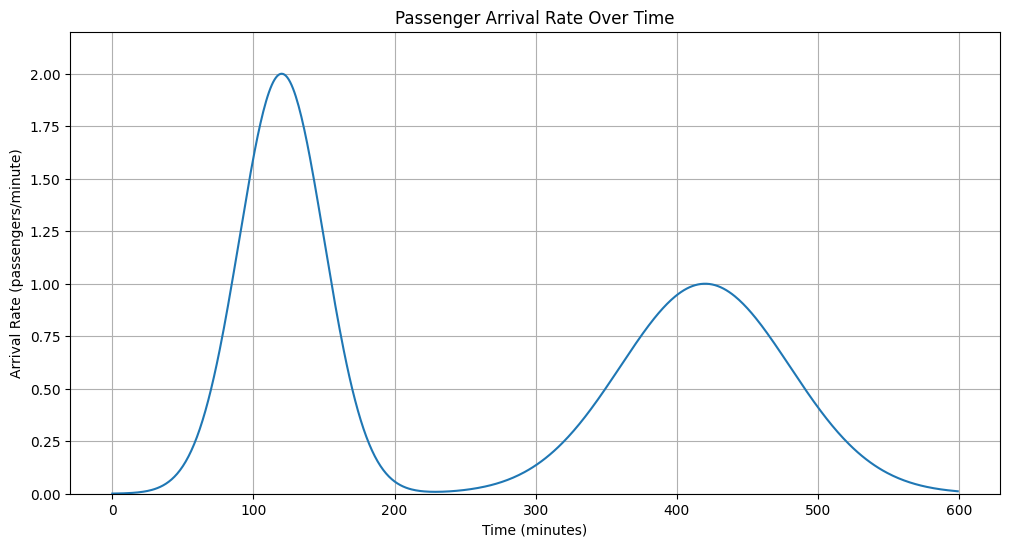

In [ ]:
## Plots the arrival rate over the simulation time.
times = range(_SIMULATION_DURATION)
rates = [calculate_arrival_rate(t) for t in times]

plt.figure(figsize=(12, 6))
plt.plot(times, rates)
plt.title('Passenger Arrival Rate Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Arrival Rate (passengers/minute)')
plt.grid(True)
plt.ylim(0, 1.1*max(rates))  # Set y-axis limit slightly above the peak rate
plt.show()

In [ ]:
def calculate_target_gates(time, n_gates_available, queue_length, current_open_gates):
    """Calculates the target number of open gates based on time and queue length."""
    # This is a simple example. You may want to implement a more sophisticated algorithm based on the inputs.

    target_gates = 1
    if time > 50:
      target_gates = n_gates_available
    if time > 150:
      target_gates = 1
    if time > 350:
      target_gates = min(n_gates_available, 3)

    return target_gates

In [ ]:
class SlowSecurityGate(SecurityGate):
    """A slow security gate with fixed attributes."""
    def __init__(self):
        super().__init__(processing_time=6, hourly_operation_cost=200)

class MediumSecurityGate(SecurityGate):
    """A medium-speed security gate with fixed attributes."""
    def __init__(self):
        super().__init__(processing_time=4, hourly_operation_cost=280)

class FastSecurityGate(SecurityGate):
    """A fast security gate with fixed attributes."""
    def __init__(self):
        super().__init__(processing_time=2, hourly_operation_cost=400)


gates_available = [SlowSecurityGate, SlowSecurityGate, MediumSecurityGate, FastSecurityGate]

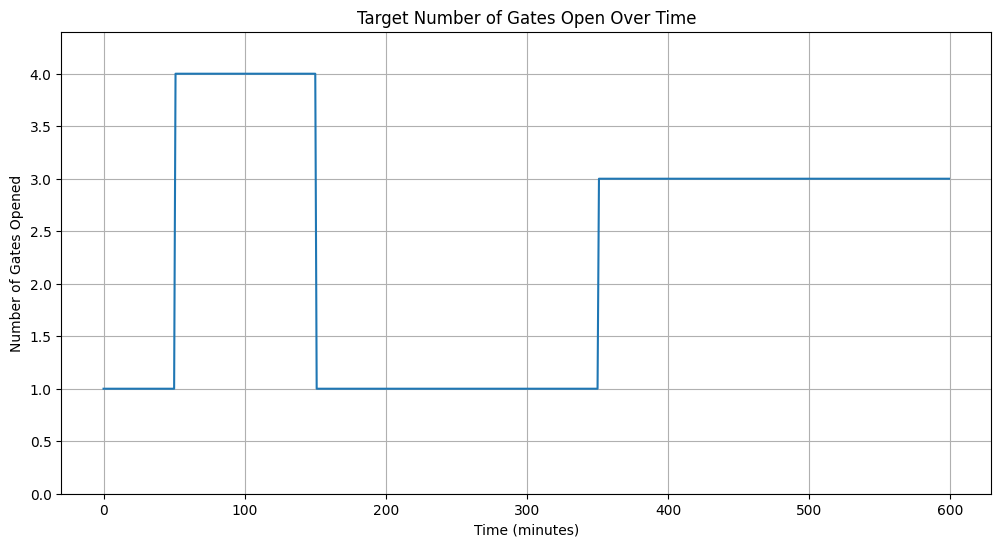

In [ ]:
## Plots the target gates over the simulation time.
times = range(_SIMULATION_DURATION)
rates = [calculate_target_gates(t, len(gates_available), None, None) for t in times]

plt.figure(figsize=(12, 6))
plt.plot(times, rates)
plt.title('Target Number of Gates Open Over Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Number of Gates Opened')
plt.grid(True)
plt.ylim(0, 1.1*max(rates))  # Set y-axis limit slightly above the peak rate
plt.show()

In [ ]:
def run_airport_simulation(gates_available):
    airport = Airport(gates_available)
    current_time = 0

    while current_time < _SIMULATION_DURATION:
        current_arrival_rate = calculate_arrival_rate(current_time)
        current_open_gates = sum(1 for gate in airport.gates if gate.is_open)
        target_gates = calculate_target_gates(current_time, airport.n_gates_available, len(airport.queue), current_open_gates)

        for i in range(math.ceil(current_arrival_rate)):
          if random.random() < current_arrival_rate - i:
            airport.add_passenger(Passenger(current_time))

        airport.process_time_step(current_time, current_arrival_rate, target_gates)
        current_time += 1

    while airport.queue or any(gate.current_passenger for gate in airport.gates if gate.is_open):
        current_open_gates = sum(1 for gate in airport.gates if gate.is_open)
        target_gates = calculate_target_gates(current_time, airport.n_gates_available, len(airport.queue), current_open_gates)
        airport.process_time_step(current_time, 0, target_gates)
        current_time += 1

    return airport.stats

In [ ]:
# Run simulation
simulation_results = run_airport_simulation(gates_available)

In [ ]:
print("Total cost of today: ${}".format(round(simulation_results['total_cost'][-1])))
max_waiting_time = round(max(simulation_results['avg_wait_time']))
print("Maximun average waiting time for today: {}min".format(max_waiting_time))
if (max_waiting_time > _MAX_WAITING_TIME_ADMISSIBLE):
  print("This simulation is a disaster, people waited too long and missed their plane!")

Total cost of today: $5831
Maximun average waiting time for today: 58min
This simulation is a disaster, people waited too long and missed their plane!


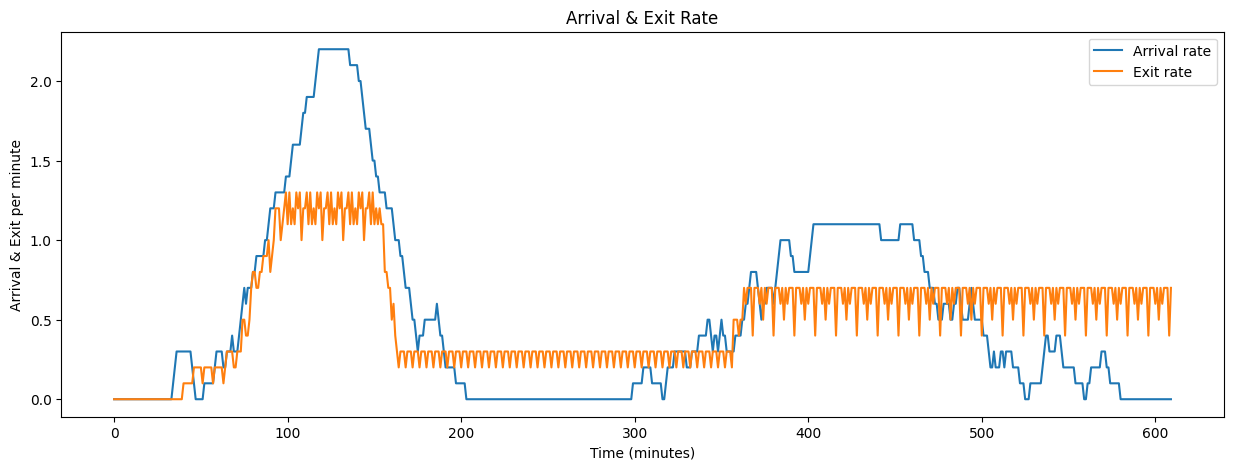

In [ ]:
fig = plt.figure(figsize=(15, 5))

plt.plot(simulation_results['time'], simulation_results['measured_arrival_rate'])
plt.plot(simulation_results['time'], simulation_results['exit_rate'])

plt.title('Arrival & Exit Rate')
plt.xlabel('Time (minutes)')
plt.ylabel('Arrival & Exit per minute')
plt.legend(['Arrival rate', 'Exit rate'])

Text(0, 0.5, 'N Gates Opened')

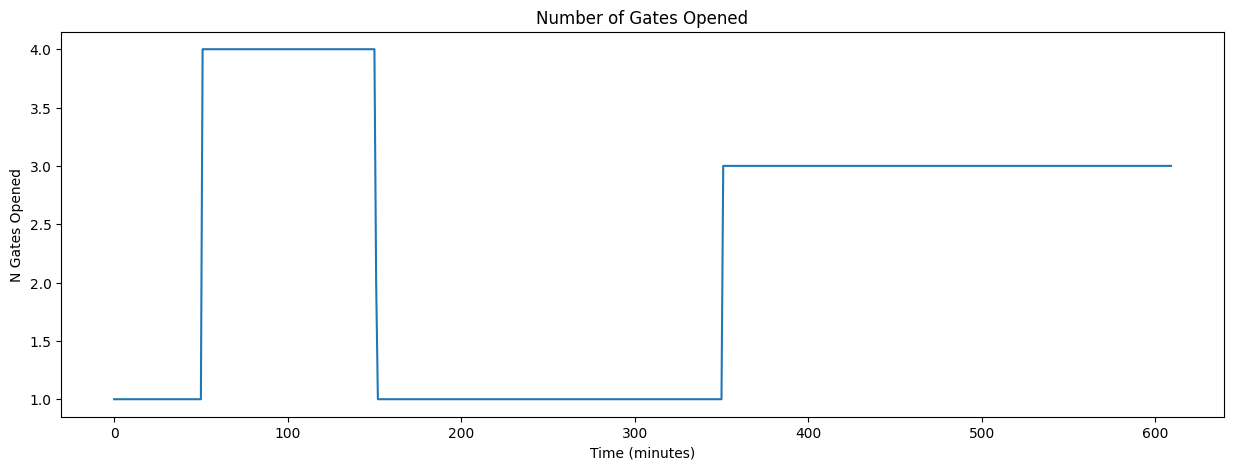

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(simulation_results['time'], simulation_results['open_gates'])
plt.title('Number of Gates Opened')
plt.xlabel('Time (minutes)')
plt.ylabel('N Gates Opened')

Text(0, 0.5, 'Queue Length')

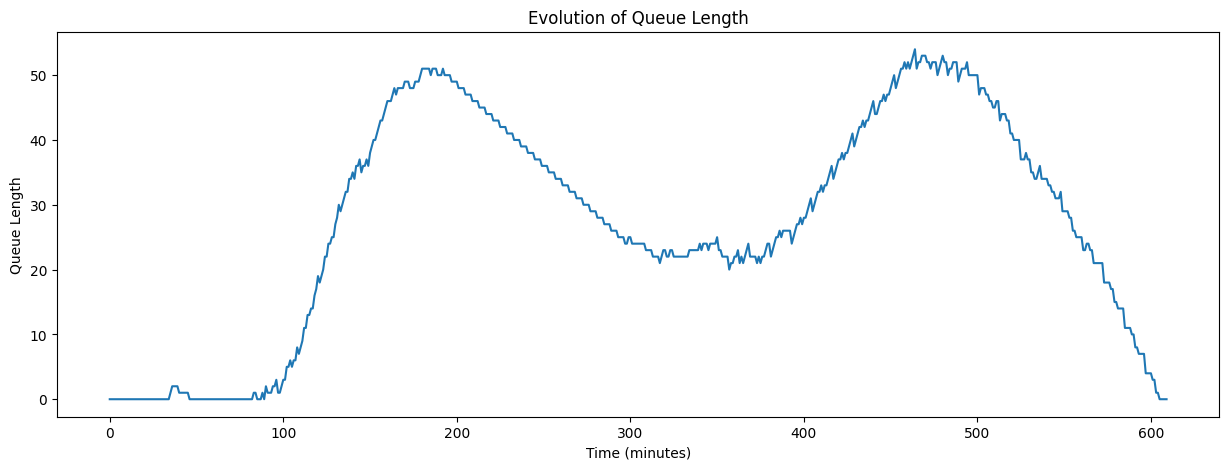

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(simulation_results['time'], simulation_results['queue_length'])
plt.title('Evolution of Queue Length')
plt.xlabel('Time (minutes)')
plt.ylabel('Queue Length')

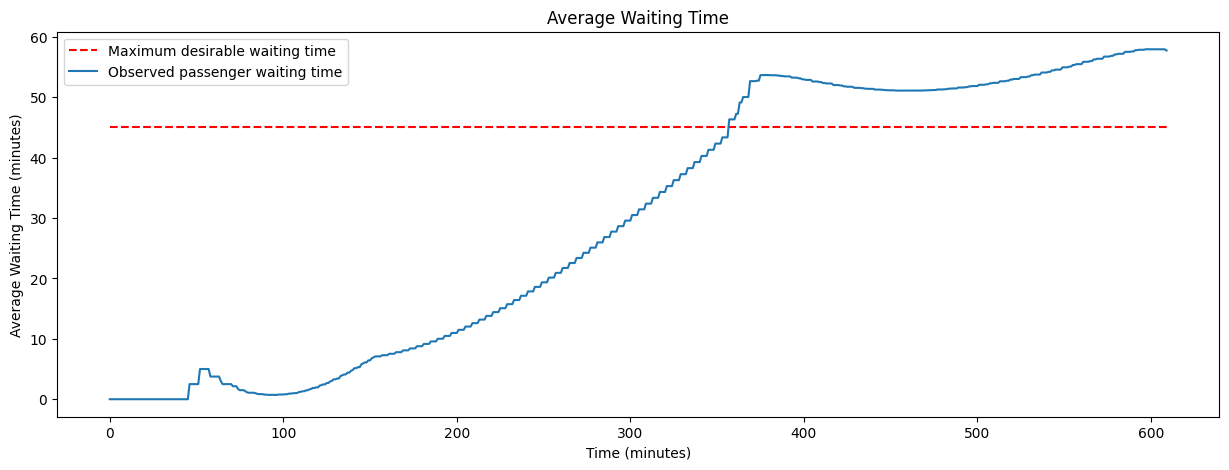

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot([0, max(simulation_results['time'])], [_MAX_WAITING_TIME_ADMISSIBLE, _MAX_WAITING_TIME_ADMISSIBLE], 'r--')
plt.plot(simulation_results['time'], simulation_results['avg_wait_time'])
plt.title('Average Waiting Time')
plt.xlabel('Time (minutes)')
plt.ylabel('Average Waiting Time (minutes)')
plt.legend(['Maximum desirable waiting time', 'Observed passenger waiting time'])

Text(0, 0.5, 'Cumulative Cost ($)')

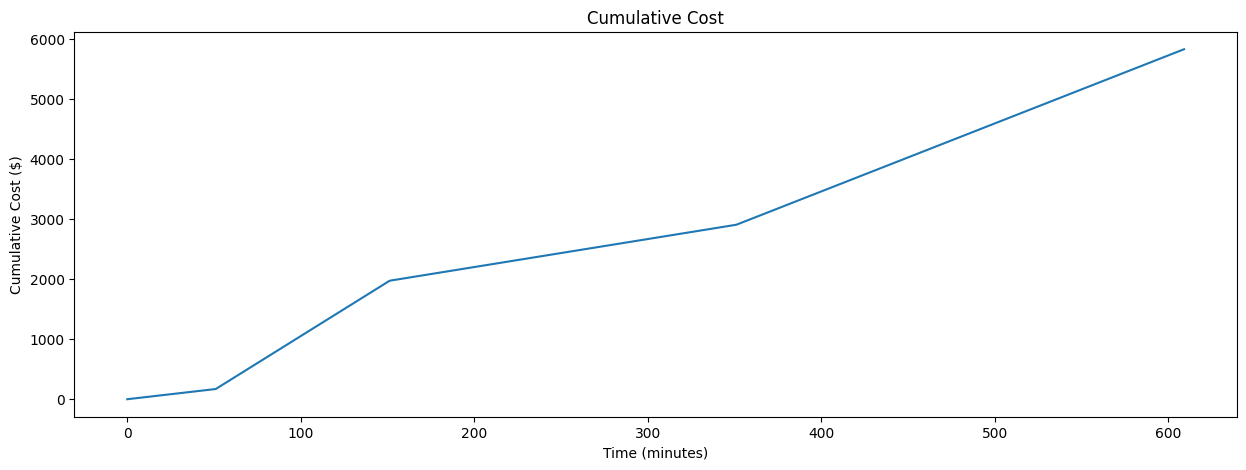

In [ ]:
fig = plt.figure(figsize=(15, 5))
plt.plot(simulation_results['time'], simulation_results['total_cost'])
plt.title('Cumulative Cost')
plt.xlabel('Time (minutes)')
plt.ylabel('Cumulative Cost ($)')